# Setup

In [81]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [82]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [83]:
# Python SQL toolkit and Object Relational Mapper (ORM)
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [84]:
# Create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [85]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [86]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [87]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [88]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Explore Database
### Get a list of column names and types

In [89]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [90]:
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [91]:
columns = inspector.get_columns("station")
for c in columns:
    print(c["name"],c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [92]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

print(most_recent_date)

('2017-08-23',)


Design a query to retrieve the last 12 months of precipitation data and plot the results. 

In [93]:
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
start_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

print(start_date)

2016-08-23


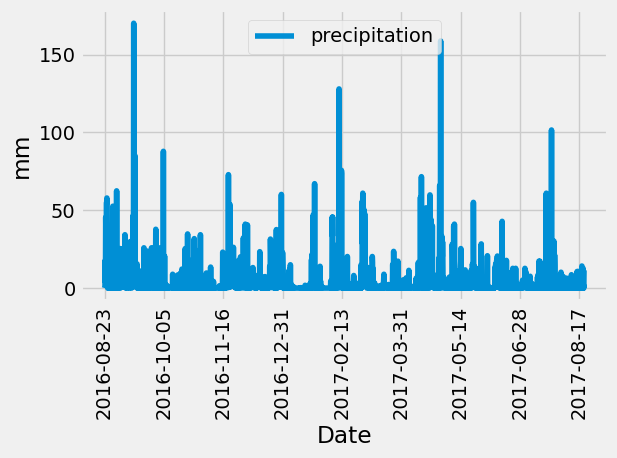

In [143]:
# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(Measurement.date, Measurement.prcp).\
      filter(Measurement.date >= start_date).all()



# Save the query results as a Pandas DataFrame. Explicitly set the column names

precipitation_df = pd.DataFrame(data=prcp_scores, columns=['Date','precipitation'])
precipitation_df = precipitation_df.dropna(how='any') #Drop None values


# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(('Date'), ascending=True)
precipitation_df = precipitation_df.set_index('Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(ax=plt.gca())
plt.xlabel("Date")
plt.ylabel("mm")
plt.xticks(rotation=90)
plt.legend(loc='upper center')
plt.tight_layout()
plt.show()

In [107]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [112]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(Station.station)).all()

[(9,)]

In [114]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
stations = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [125]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),\
       func.max(Measurement.tobs),\
       func.avg(Measurement.tobs)]
most_active_station_temps = session.query(*sel).\
        filter(Measurement.station == "USC00519281").\
        group_by(Measurement.station).\
        order_by(Measurement.station).all()
print(most_active_station_temps)

[(12.2, 29.4, 22.03582251082252)]


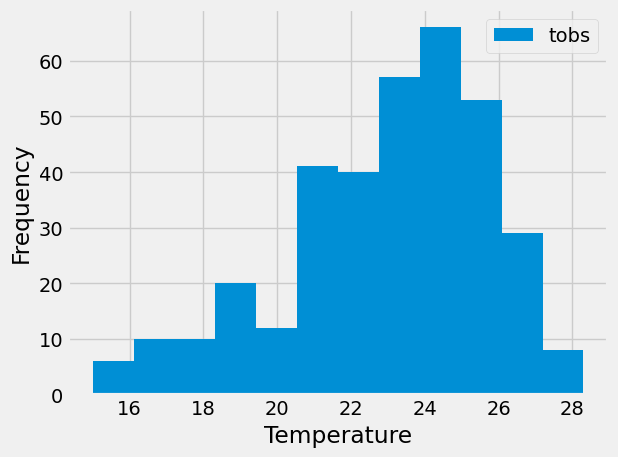

In [145]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
filter(Measurement.station == 'USC00519281').\
filter(Measurement.date >= start_date).all()
#print(results)
df = pd.DataFrame(results, columns=['tobs'])

df.plot.hist(bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close Session

In [146]:
# Close Session
session.close()